
## Analyzing YouTube Video Data from News Publishers

##### This task focuses on analyzing YouTube videos about Covid-19 published by 4 English news publishers  BBC, Fox News, CNN and MSNBC from a start date to an end date. The data is collected using the file collect.ipynb. 
<img src="youtube.png" alt="SIT112 Avocado!" width="1800" height="200">

### A. Settings


In [3]:
from datetime import datetime
VIDEOS_FILE = "videos.csv"
COMMENTS_FILE = "comments.csv"
CREDENTIALS_FILE = 'credentials.ini'
START_DATE = datetime(2020, 1, 1)
END_DATE = datetime(2021, 1, 1)
KEYWORDS =['coronavirus', 'covid', 'covid-19', 'pandemic']
# You can use function get_channel_info() to extract the channel ID of a sample video from a news publisher ...
CHANNELS = {
    'UCXIJgqnII2ZOINSWNOGFThA' : 'Fox News',
    'UC16niRr50-MSBwiO3YDb3RA' : 'BBC News',
    'UCupvZG-5ko_eiXAupbDfxWw' : 'CNN',
    'UCaXkIU1QidjPwiAYu6GcHjg' : 'MSNBC'
}
MAX_VIDEOS = 50 # the maximum number of video that should be returned for each request. Acceptable values are 0 to 50
QUERY= f"intitle:{','.join(KEYWORDS)}"

### B. Imports
You need to import the following libraries. Install the libraries using "conda install ... or pip install ..." if they have not been installed on your machine. For example you can install google api python client by executing "conda install google-api-python-client"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from datetime import datetime
import os
from configparser import ConfigParser
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
from langdetect import detect
import langdetect
from textblob import TextBlob
import calendar
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from prettytable import PrettyTable
from tabulate import tabulate
import numpy as np
from collections import defaultdict
import warnings
import datetime
from nltk.stem import WordNetLemmatizer
from pandas.errors import SettingWithCopyWarning
from scipy import stats

# Ignore the warning
warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


### C. Clean and Prepare the Data

In [ ]:
# a basic data cleaning has been performed on the collected data by the clean_data()function in collect.ipynb
# additionl data cleaning can be added here - if needed  

##### C.1. Python code that prepares the data for analyzing the videos and comments.

In [4]:
# A sample code for data preparation has been given below. Feel free to edit when needed

# Load the videos and comments dataframes from their respective CSV files
videos_df = pd.read_csv('videos.csv')
comments_df = pd.read_csv('comments.csv')

# Convert the published_at column to a datetime object for videos_df
videos_df['published_at'] = pd.to_datetime(videos_df['published_at'], format='%Y-%m-%dT%H:%M:%SZ')

# Create a new column that contains the published_at weekly
videos_df['published_at_week'] = videos_df['published_at'].dt.strftime('%Y-%m-%W')

# Create a new column that contains the published_at monthly
videos_df['published_at_month'] = videos_df['published_at'].dt.strftime('%Y-%m')

# Create a new column that contains the published_at monthly
videos_df['published_at_year'] = videos_df['published_at'].dt.strftime('%Y')

# Convert the published_at column to a datetime object for comments_df
comments_df['comment_date'] = pd.to_datetime(comments_df['comment_date'], format='%Y-%m-%dT%H:%M:%SZ')

# Create a new column that contains the published_at weekly
comments_df['comment_date_week'] = comments_df['comment_date'].dt.strftime('%Y-%m-%W')

# Create a new column that contains the published_at monthly
comments_df['comment_date_month'] = comments_df['comment_date'].dt.strftime('%Y-%m')

# Create a new column that contains the published_at monthly
comments_df['comment_date_year'] = comments_df['comment_date'].dt.strftime('%Y')

# Convert the duration column to seconds for videos_df
videos_df['duration'] = videos_df['duration'].apply(lambda x: re.findall(r'PT(\d+)M(\d+)S', x))
videos_df['duration'] = videos_df['duration'].apply(lambda x: int(x[0][0]) * 60 + int(x[0][1]) if len(x) > 0 else 0)

# Prepared DataFrame objects; can be used for data analysis
videos = videos_df
comments = comments_df
videos_comments = pd.merge(videos,comments, on='video_id', how = 'inner') # merged videos and comments


##### C.2.Python code that takes a text input and returns its sentiment (polarity) score and sentiment category (positive, negative, neutral)

In [5]:
# This function takes a text input and returns its sentiment (polarity) score
# If the text is null, it returns 0
def get_sentiment_score(text):
    if pd.isnull(text):
        return 0
    else:
        return TextBlob(text).sentiment.polarity
    
# This function takes a text input and returns its sentiment category
# If the text is null, it returns 'neutral'
# If the polarity score is greater than 0, it returns 'positive'
# If the polarity score is less than 0, it returns 'negative'
# Otherwise, it returns 'neutral'
def get_sentiment(text):
    if pd.isnull(text):
        return 'neutral'
    else:
        blob = TextBlob(text)
        if blob.sentiment.polarity > 0:
            return 'positive'
        elif blob.sentiment.polarity < 0:
            return 'negative'
        else:
            return 'neutral'

##### D.1.1 Compare the distributions of the number of views, likes, and comments for the videos. 

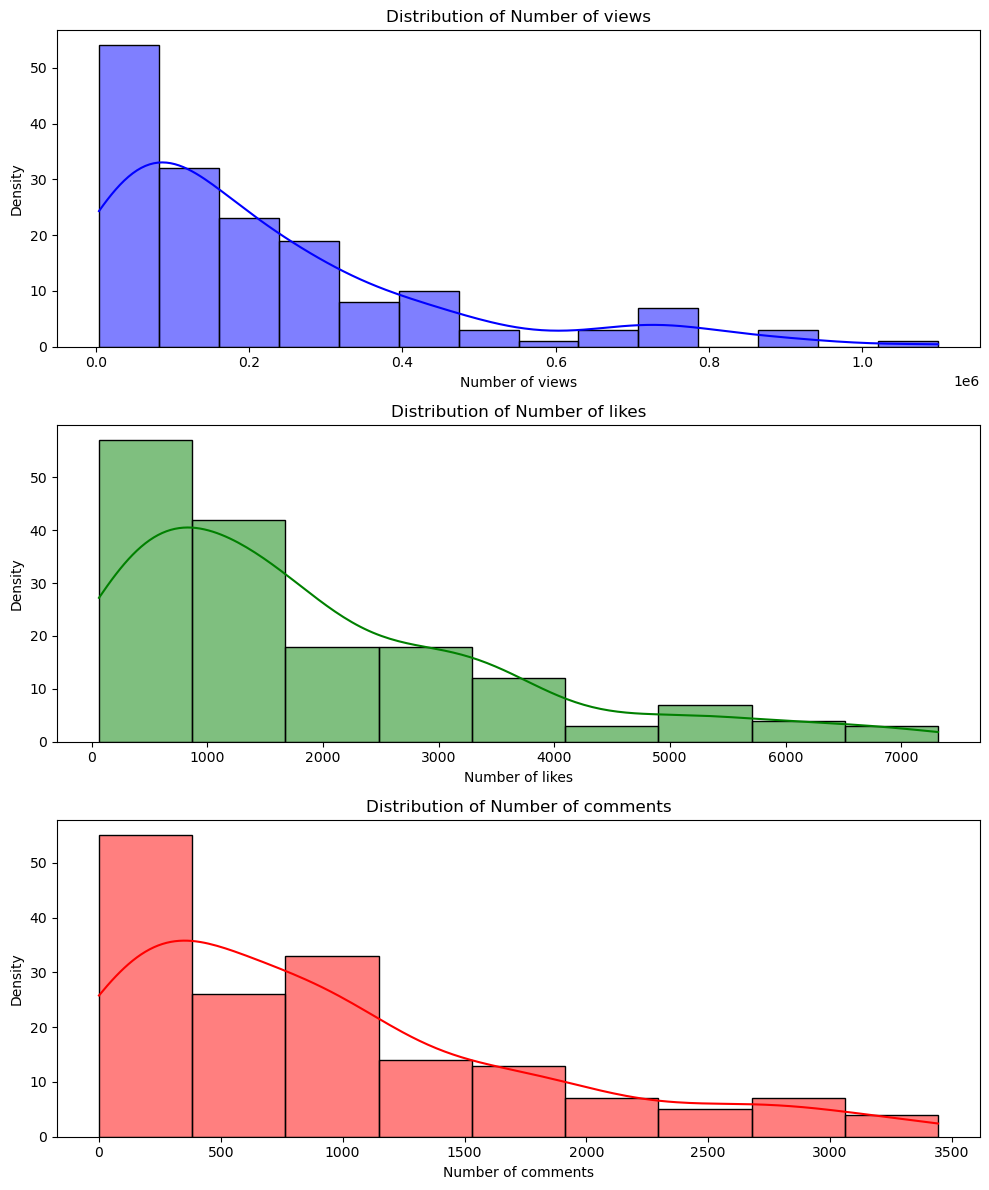

In [6]:


# Rename columns
videos.rename(columns={'view_count': 'number of views',
                       'like_count': 'number of likes',
                       'comment_count': 'number of comments'}, inplace=True)
column_names = ['number of views', 'number of likes', 'number of comments']

# Function to remove outliers using IQR
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data

# Filter outliers for each column
filtered_videos = videos.copy()
for column in column_names:
    filtered_videos = remove_outliers(filtered_videos, column)

colors = ['blue', 'green', 'red']
# Create a figure with three subplots using a 3x1 grid
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Loop over the columns and plot a histogram on each subplot
for i, column in enumerate(column_names):
    ax = sns.histplot(filtered_videos[column], kde=True, ax=axes[i], color=colors[i])
    ax.set_title(f'Distribution of {column.capitalize()}')
    ax.set_xlabel(column.capitalize())
    ax.set_ylabel('Density')
plt.tight_layout()

# Customize and display the plot
plt.show()




Observation 1: 
The histogram depicts that most of the videos receive from 0 to 100000 viewers (about 60 videos). This figure is followed by the nearly 30 videos with 100k to 200k views. The number keeps on decreasing in the following views categories and stops at 2 videos reaching the highest attention of 1 millions views

Observation 2: 
Looking at the number of likes histogram, we can see that most of the videos' like count falls within the range of 0-1500. The figure then experienced a plummet as the number of likes increase.

Observation 3:
The same trend applies to the historgram of number of comments. It shows that about 60 videos receive from 0 to 500 comments whereas this number for the range of 500 to 1000 is only 25. Then, the figures progressively falls as the comments range moves up. 

##### D.1.2.The total number of views, likes, and comments for the videos published by different news publishers (channels).

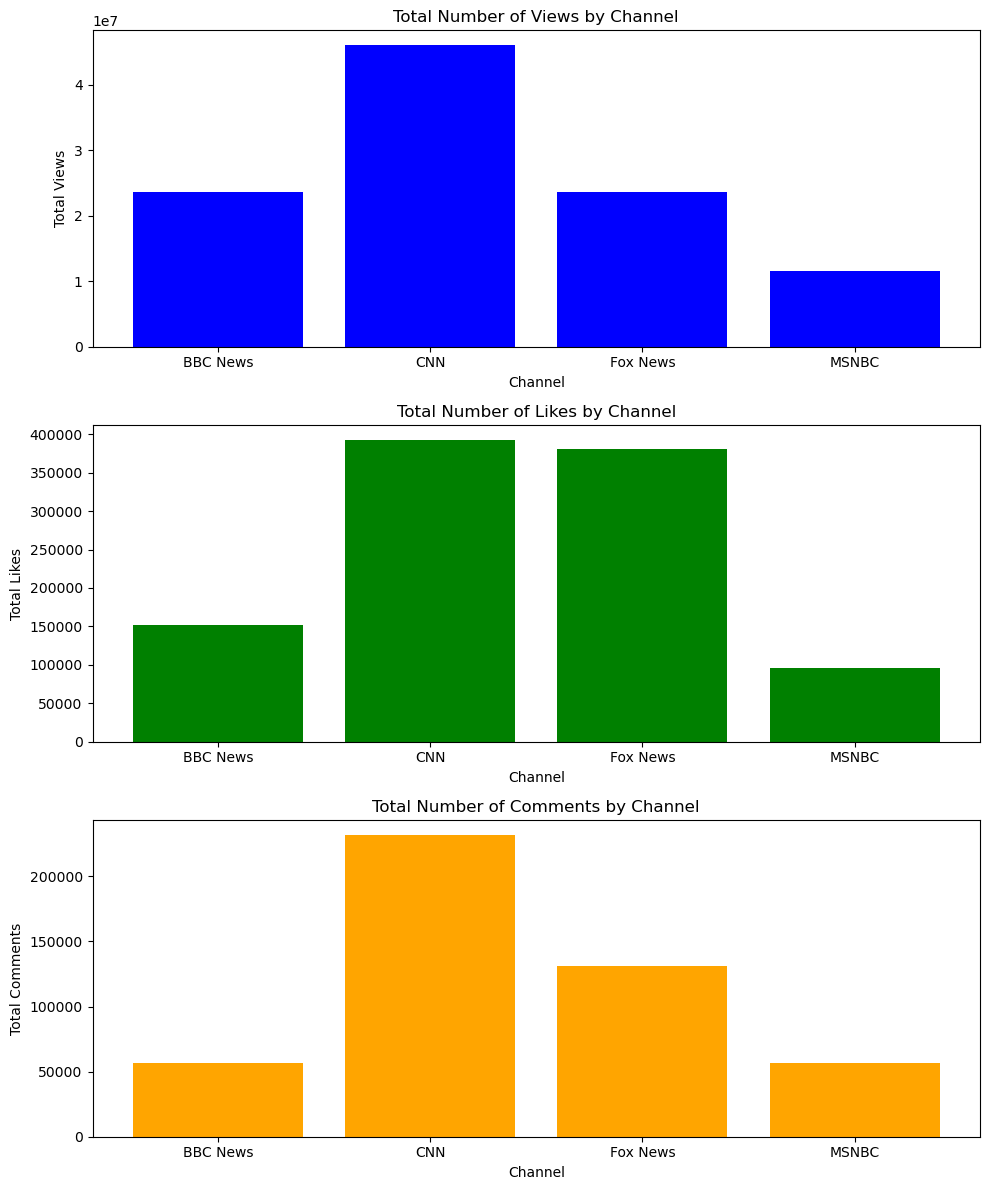

In [8]:
# Write your code here:
video_data = pd.read_csv("videos.csv")

# Calculate total views, likes, and comments by publisher
publishers_data = video_data.groupby("channel_title").agg({"view_count":"sum", "like_count":"sum", "comment_count":"sum"}).reset_index()
publishers_data.rename(columns={'view_count': 'views',
                           'like_count': 'likes',
                           'comment_count': 'comments'}, inplace=True)

variables = ['views', 'likes', 'comments']
colors = ['blue', 'green', 'orange']
titles = ['Total Number of Views by Channel', 'Total Number of Likes by Channel', 'Total Number of Comments by Channel']
ylabels = ['Total Views', 'Total Likes', 'Total Comments']


# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
# Plot total number of views, likes, and comments by publisher
for i, (variable, color, title, ylabel) in enumerate(zip(variables, colors, titles, ylabels)):
    ax = axes[i]
    ax.bar(publishers_data['channel_title'], publishers_data[variable], color=color)
    ax.set_title(title)
    ax.set_xlabel('Channel')
    ax.set_ylabel(ylabel)

# Customize and display the plot
plt.tight_layout()
plt.show()



Observation 1: 
In the first bar graph, CNN is in the lead of the channel with the highest total number of views(roughly 4.8 million views). The second place is shared by BBC and Fox news with nearly 2.5 million views. 

Observation 2: 
The same trend applies to the bar chart showcasing total number of comments. CNN news stills outplays with more than 250k comments in total. And Fox News follows by 125k comments reveived.

Observation 3:
In the chart of the likes number, the first position is being shared by Fox news and CNN with the same number of 380000 comments. Now, BBC News is the second-last channel receiving about 150000 likes and this is followd by MSNBC with 100000 likes.


##### D.1.3. How does the average length of the comments (in characters) on a video vary with its duration? 

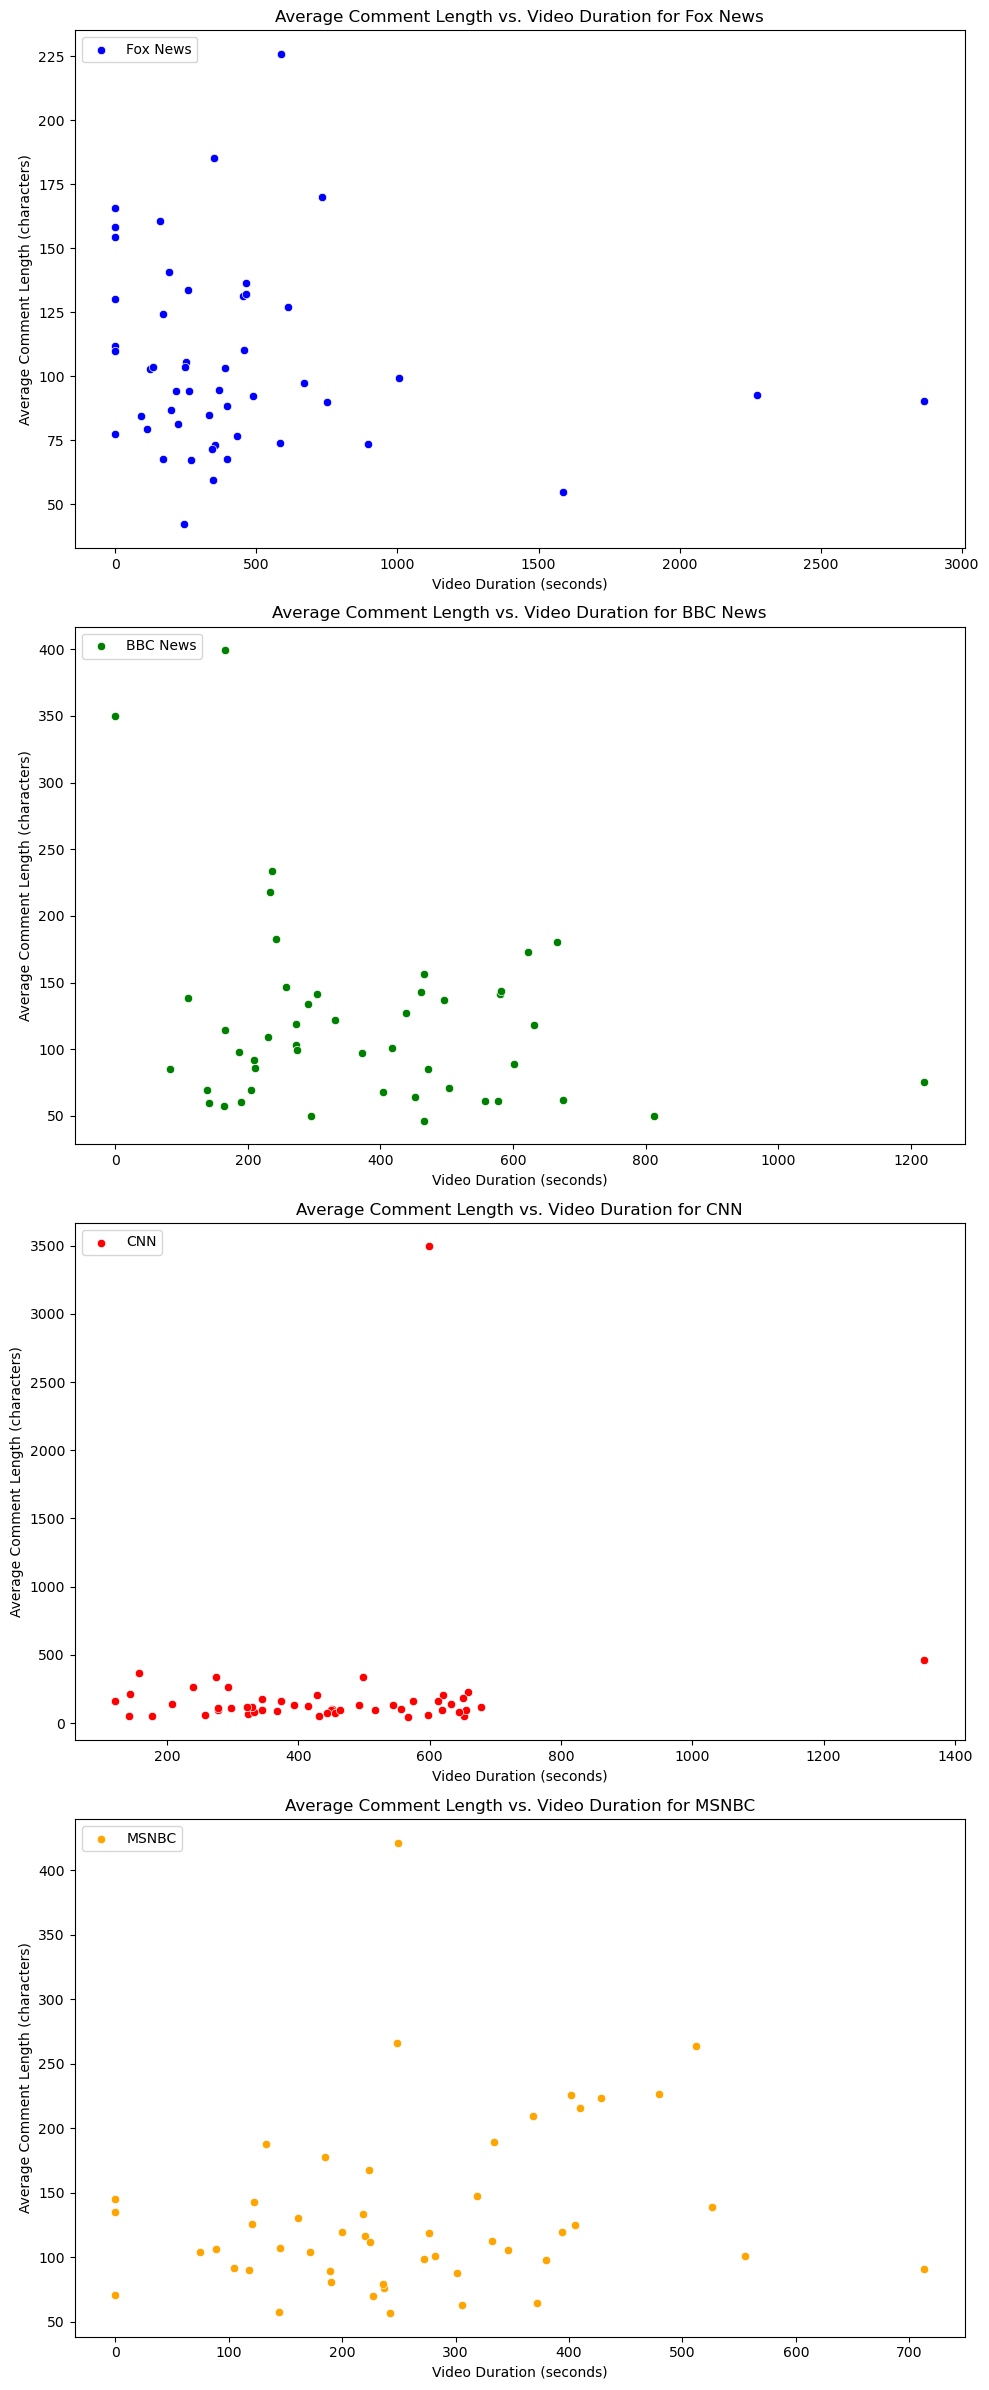

In [28]:

# Create a new DataFrame containing only the comments data
comments_data = pd.read_csv("comments.csv")
# Add a new column to the DataFrame to store the length of each comment
comments_data["comment_length"] = comments_data["comment_text"].str.len()
# Group the comments DataFrame by video_id and calculate the mean comment length for each video
mean_comment_length = comments_data.groupby('video_id')['comment_length'].mean().reset_index()

# Merge the videos DataFrame with grouped comments DataFrame 
merged_data = pd.merge(videos, mean_comment_length, on='video_id', how='left')

# Create subplots for each channel
channels = merged_data['channel_title'].unique()
num_channels = len(channels)
fig, axes = plt.subplots(num_channels, 1, figsize=(10, 6*num_channels))
colors = ['blue', 'green', 'red','orange']
# Customize and display the subplots
for i, channel in enumerate(channels):
    channel_data = merged_data[merged_data['channel_title'] == channel]
    sns.scatterplot(x='duration', y='comment_length', data=channel_data, ax=axes[i], color=colors[i])
    axes[i].set_title(f'Average Comment Length vs. Video Duration for {channel}')
    axes[i].set_xlabel('Video Duration (seconds)')
    axes[i].set_ylabel('Average Comment Length (characters)')
    axes[i].legend([channel], loc='upper left')

plt.tight_layout()
plt.show()


Observation 1: 
For the data of Fox News and BBC News, there is a weak correlation between the video duration and the average comments length. We can easily see that in the first ranges of both scatterplots, the comments vary from 100 to 300 characters.  Moreover, the longer videos also received comments with flucuating lengths. 

Observation 2:
The plots for MSNBC and CNN start to show weak relationships between the two fields. The longer videos are, the longer the comments extends. However, we still observe some variabilities in the plots. 
...

### E. Analyze the Videos and Comments


##### E.1.  The monthly distribution of the positive, negative, and neutral sentiments in the video titles and comments from Jan 2020 to Jan 2021?

<Figure size 3000x1000 with 0 Axes>

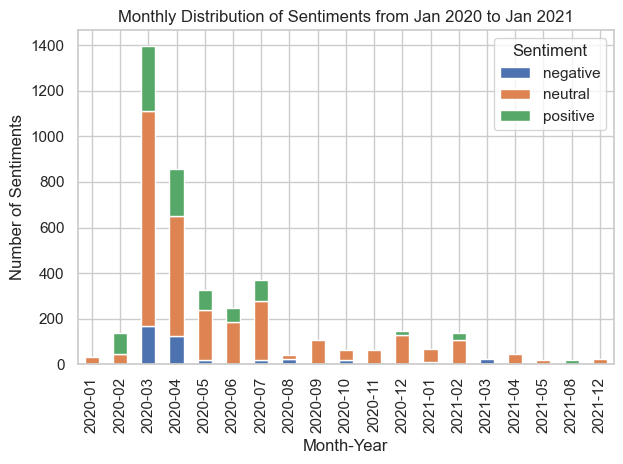

<Figure size 3000x1000 with 0 Axes>

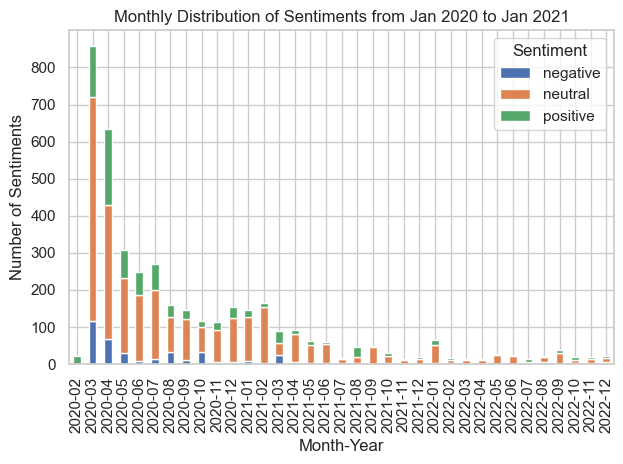

In [49]:
# load the data
videos_comments = videos_comments[(videos_comments["published_at"]>= START_DATE) & (videos_comments["published_at"]<= END_DATE) & (videos_comments["comment_date"]>= START_DATE) & (videos_comments["comment_date"]<= END_DATE) ]

# extract year and month from published_at and comment_date columns
target = videos_comments.loc[: ,["video_title", "comment_text", "published_at", "comment_date"]]
target["video_time"]=target["published_at"].dt.strftime('%Y-%m')
target["comment_time"]=target["comment_date"].dt.strftime('%Y-%m')

# apply the get_sentiment function to the video titles to get the sentiment
target["title_sent"] = target["video_title"].apply(get_sentiment)
# apply the get_sentiment function to the comments to get the sentiment
target["comment_sent"] = target["video_title"].apply(get_sentiment)

target
# define start and end date for data analysis
vid_analysis = target.groupby(["video_time", "title_sent"]).size().unstack(fill_value=0)
plt.figure(figsize=(30, 10))
vid_analysis.plot(kind='bar', stacked=True)
plt.title('Monthly Distribution of Sentiments from Jan 2020 to Jan 2021')
plt.xlabel('Month-Year')
plt.ylabel('Number of Sentiments')
plt.legend(title='Sentiment')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


comment_analysis = target.groupby(["comment_time", "title_sent"]).size().unstack(fill_value=0)
plt.figure(figsize=(30, 10))
comment_analysis.plot(kind='bar', stacked=True)
plt.title('Monthly Distribution of Sentiments from Jan 2020 to Jan 2021')
plt.xlabel('Month-Year')
plt.ylabel('Number of Sentiments')
plt.legend(title='Sentiment')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



##### E.2. Use regression analysis with visualization to test the following hypothesises:

* H1: There is a meaningful relationship between the sentiment of a video title and the sentiments of its corresponding comments.  
* H2: There is a meaningful relationship between the video likes and the sentiments of its corresponding comments.
* H3: There is a meaningful relationship between the duration of a video and the sentiments of its corresponding comments.

-0.0780958340652953


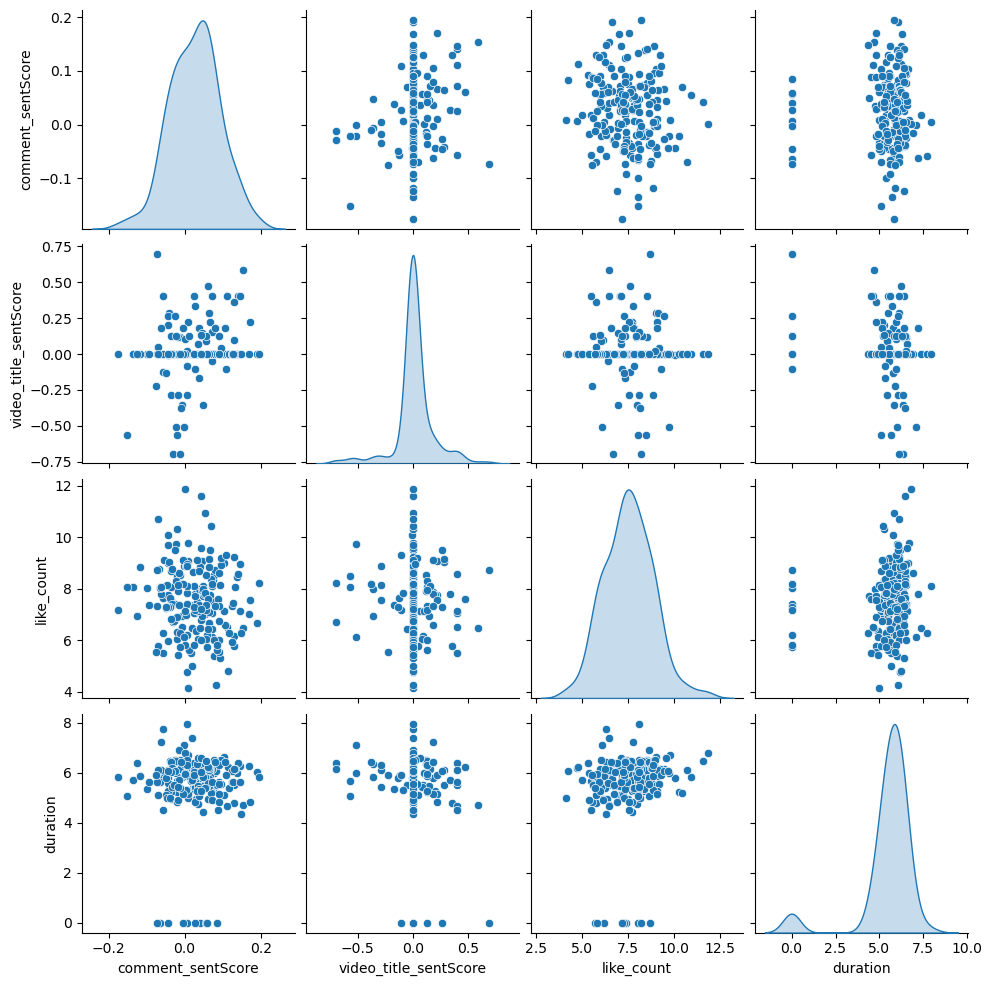

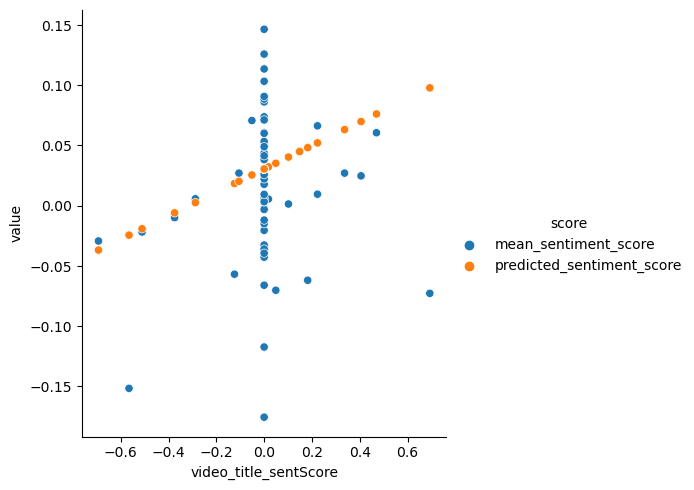

In [14]:
# load the data
from sklearn.model_selection import train_test_split
from sklearn. linear_model import LinearRegression

# apply the get_sentiment_score and get_sentiment functions to the video titles to get the sentiment scores and sentiment categories respectively
videos_comments["video_title_sentScore"] = videos_comments["video_title"].apply(get_sentiment_score)
videos_comments["video_title_sentiment"] =  videos_comments["video_title"].apply(get_sentiment)

# apply the get_sentiment_score and get_sentiment functions to the comments to get the sentiment scores and sentiment categories respectively
videos_comments["comment_sentScore"] = videos_comments["comment_text"].apply(get_sentiment_score)
videos_comments["comment_sentiment"] = videos_comments["comment_text"].apply(get_sentiment)

# group the comments by video and calculate the average sentiment score of comments and sentiment score for each video title
data  = videos_comments.groupby(["video_title","video_title_sentScore", "duration","like_count"]).agg({"comment_sentScore":"mean"}).reset_index()
transform_data = np.log1p(data[["video_title_sentScore", "duration","like_count", "comment_sentScore"]])
sns.pairplot(data=transform_data, y_vars=["comment_sentScore","video_title_sentScore","like_count", "duration"], x_vars=["comment_sentScore","video_title_sentScore","like_count", "duration"], diag_kind="kde")

x_train, x_test, y_train, y_test= train_test_split(transform_data[["video_title_sentScore"]], transform_data[["comment_sentScore"]], test_size = 0.3, random_state = 44)
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
print(linear_model.score(x_test, y_test))
sentiment_predict = linear_model.predict(x_test)

result_df = pd.concat([x_test. reset_index(drop=True), y_test.reset_index(drop=True),
pd.DataFrame(sentiment_predict)], axis=1)
result_df.columns = ["video_title_sentScore", "mean_sentiment_score", "predicted_sentiment_score"]
hypo1 = pd.melt(result_df, id_vars = "video_title_sentScore", value_vars = ["mean_sentiment_score", "predicted_sentiment_score"], var_name = "score", value_name = "value")

sns.relplot( x = "video_title_sentScore", y = "value",data=hypo1, hue="score")


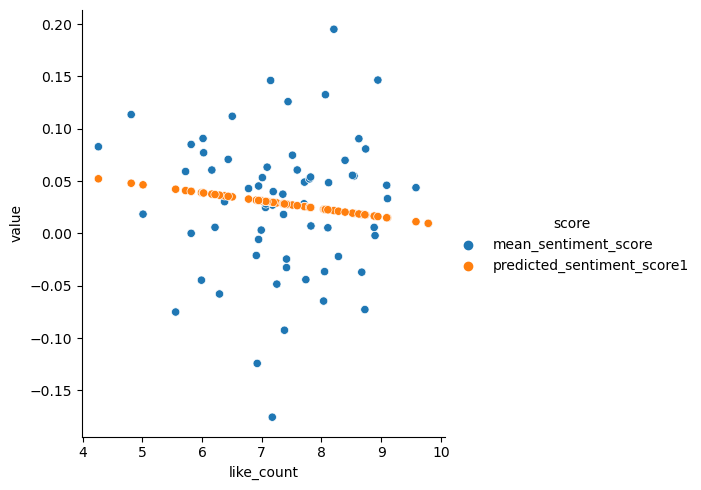

In [17]:

x_train1, x_test1, y_train1, y_test1= train_test_split(transform_data[["like_count"]], transform_data[["comment_sentScore"]], test_size = 0.33, random_state = 52)
linear_model1 = LinearRegression()
linear_model1.fit(x_train1, y_train1)
linear_model1.score(x_test1, y_test1)
sentiment_predict1 = linear_model1.predict(x_test1)

result1_df = pd.concat([x_test1. reset_index(drop=True), y_test1.reset_index(drop=True),
pd.DataFrame(sentiment_predict1)], axis=1)
result1_df.columns = ["like_count", "mean_sentiment_score", "predicted_sentiment_score1"]
hypo2 = pd.melt(result1_df, id_vars = "like_count", value_vars = ["mean_sentiment_score", "predicted_sentiment_score1"], var_name = "score", value_name = "value")
#hypo1
sns.relplot(data=hypo2, x = "like_count", y = "value", hue="score")
# plot the second subplot



 

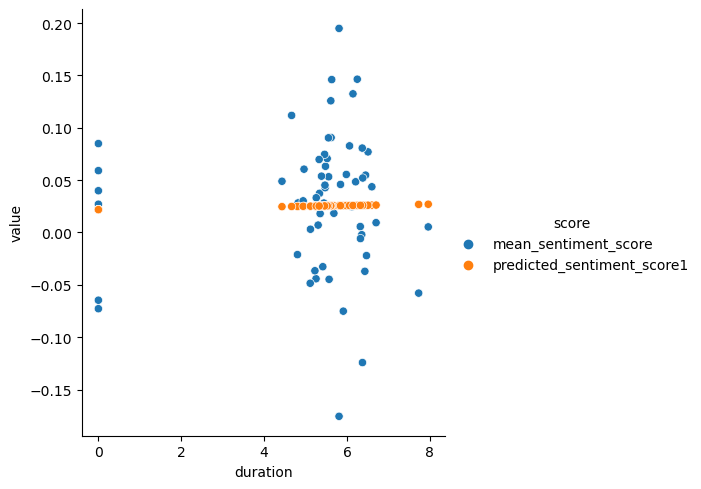

In [18]:
# group the comments by video and calculate the average sentiment score and duration for each video

x_train2, x_test2, y_train2, y_test2= train_test_split(transform_data[["duration"]], transform_data[["comment_sentScore"]], test_size = 0.30, random_state = 52)
linear_model2 = LinearRegression()
linear_model2.fit(x_train2, y_train2)
linear_model2.score(x_test2, y_test2)
sentiment_predict2 = linear_model2.predict(x_test2)

result2_df = pd.concat([x_test2. reset_index(drop=True), y_test2.reset_index(drop=True),
pd.DataFrame(sentiment_predict2)], axis=1)
result2_df.columns = ["duration", "mean_sentiment_score", "predicted_sentiment_score1"]
hypo3 = pd.melt(result2_df, id_vars = "duration", value_vars = ["mean_sentiment_score", "predicted_sentiment_score1"], var_name = "score", value_name = "value")

sns.relplot(data=hypo3, x = "duration", y = "value", hue="score")

##### E.3. Check if the following hypothesis is true: Video titles that contain certain words are more likely to elicit certain sentiments in the comments. Use visualization and discuss your observations. Use function get_sentiment_score().

Approach: Use natural language processing (NLP) techniques to clean the video titles and count the occurrence of words in them. Group the video titles by their associated sentiment categories (positive, negative, neautral) and filter out words that are frequent across all sentiment categories. You can visualize the relationship between sentiment and word prevalence by creating word clouds for each sentiment category.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/macbook/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


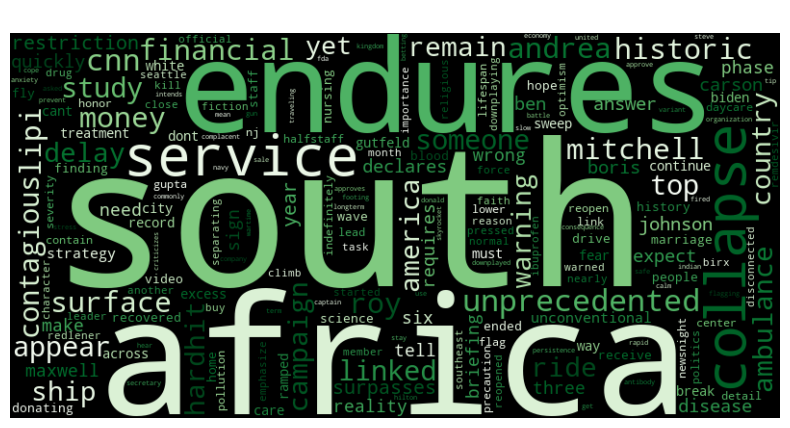

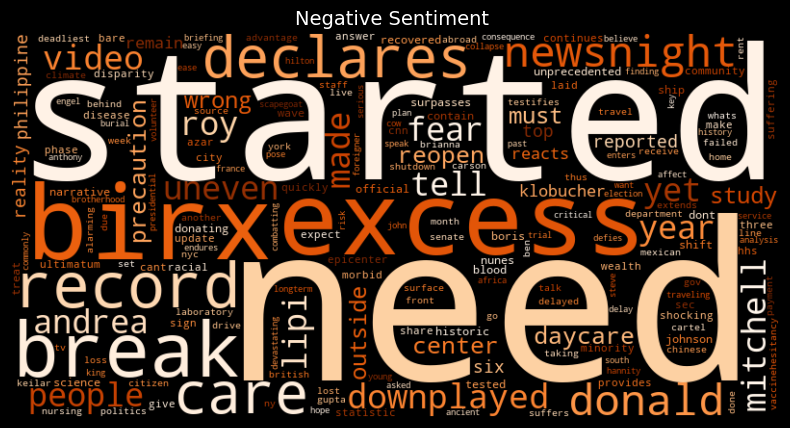

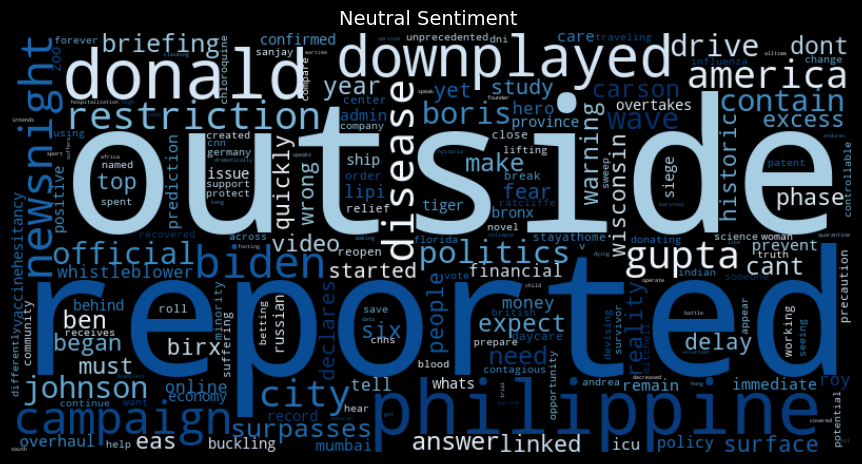

In [7]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data files
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

# Initialize the stop words and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()




#Method to clean a text
def clean_text(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        raise ValueError("Input text must be a string")
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))  
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize tokens
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Join tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text
    
def extract_words(text):
    return re.findall(r'\b\w+\b', text.lower())  # Find all word-like substrings in lowercase text


#Prepare the data
analytics = videos_comments.loc[:,["video_title", "comment_text"]]

#Clean the title of the videos and extract the words
analytics["clean_title"] = analytics["video_title"].apply(clean_text)
analytics["word"] = analytics["clean_title"].apply(extract_words)
#Calculate the sentiment score of the comments and categorize them
analytics["comment_score"] = analytics["comment_text"].apply(get_sentiment_score)
analytics["category"] = analytics["comment_text"].apply(get_sentiment)

# Group by sentiment category and collect all tokens in each category
positive = analytics[analytics["category"] == "positive"]["word"].sum()
negative = analytics[analytics["category"] == "negative"]["word"].sum()
neutral = analytics[analytics["category"] == "neutral"]["word"].sum()

#Count the words in each category
positive_counts = Counter(positive)
negative_counts = Counter(negative)
neutral_counts = Counter(neutral)


# Identify too frequent words in all categories
def find_frequent_words(positive_counts, negative_counts, neutral_counts):

  # Combine all word counts
  all_counts = Counter(positive_counts) + Counter(negative_counts) + Counter(neutral_counts)

  # Filter frequent words based on threshold
  frequent_words = {word: count for word, count in all_counts.items() if count >= 50  }

  return frequent_words
    
common_words = find_frequent_words(positive_counts, negative_counts, neutral_counts)
# Method to filter out common words    
def filter_common_words(counter, common_words):
    for word in common_words:
        if word in counter:
            del counter[word]
    return counter

#Method to generate a wordcloud
def generate_wordcloud(word_counts, title, color):
    wordcloud = WordCloud(width=800, height=400, background_color="black", colormap = color).generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.style.use("dark_background")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.title(title, fontsize=14)
#Filter out the frequent words
positive_words = filter_common_words(positive_counts, common_words)
negative_words = filter_common_words(negative_counts, common_words)
neutral_words = filter_common_words(neutral_counts, common_words)

#Generate the wordcloud for each category
generate_wordcloud(positive_words, "Positive Sentiment ","Greens")
generate_wordcloud(negative_words, "Negative Sentiment ","Oranges")
generate_wordcloud(neutral_words, "Neutral Sentiment ","Blues")

plt.tight_layout(pad=2)
plt.show()


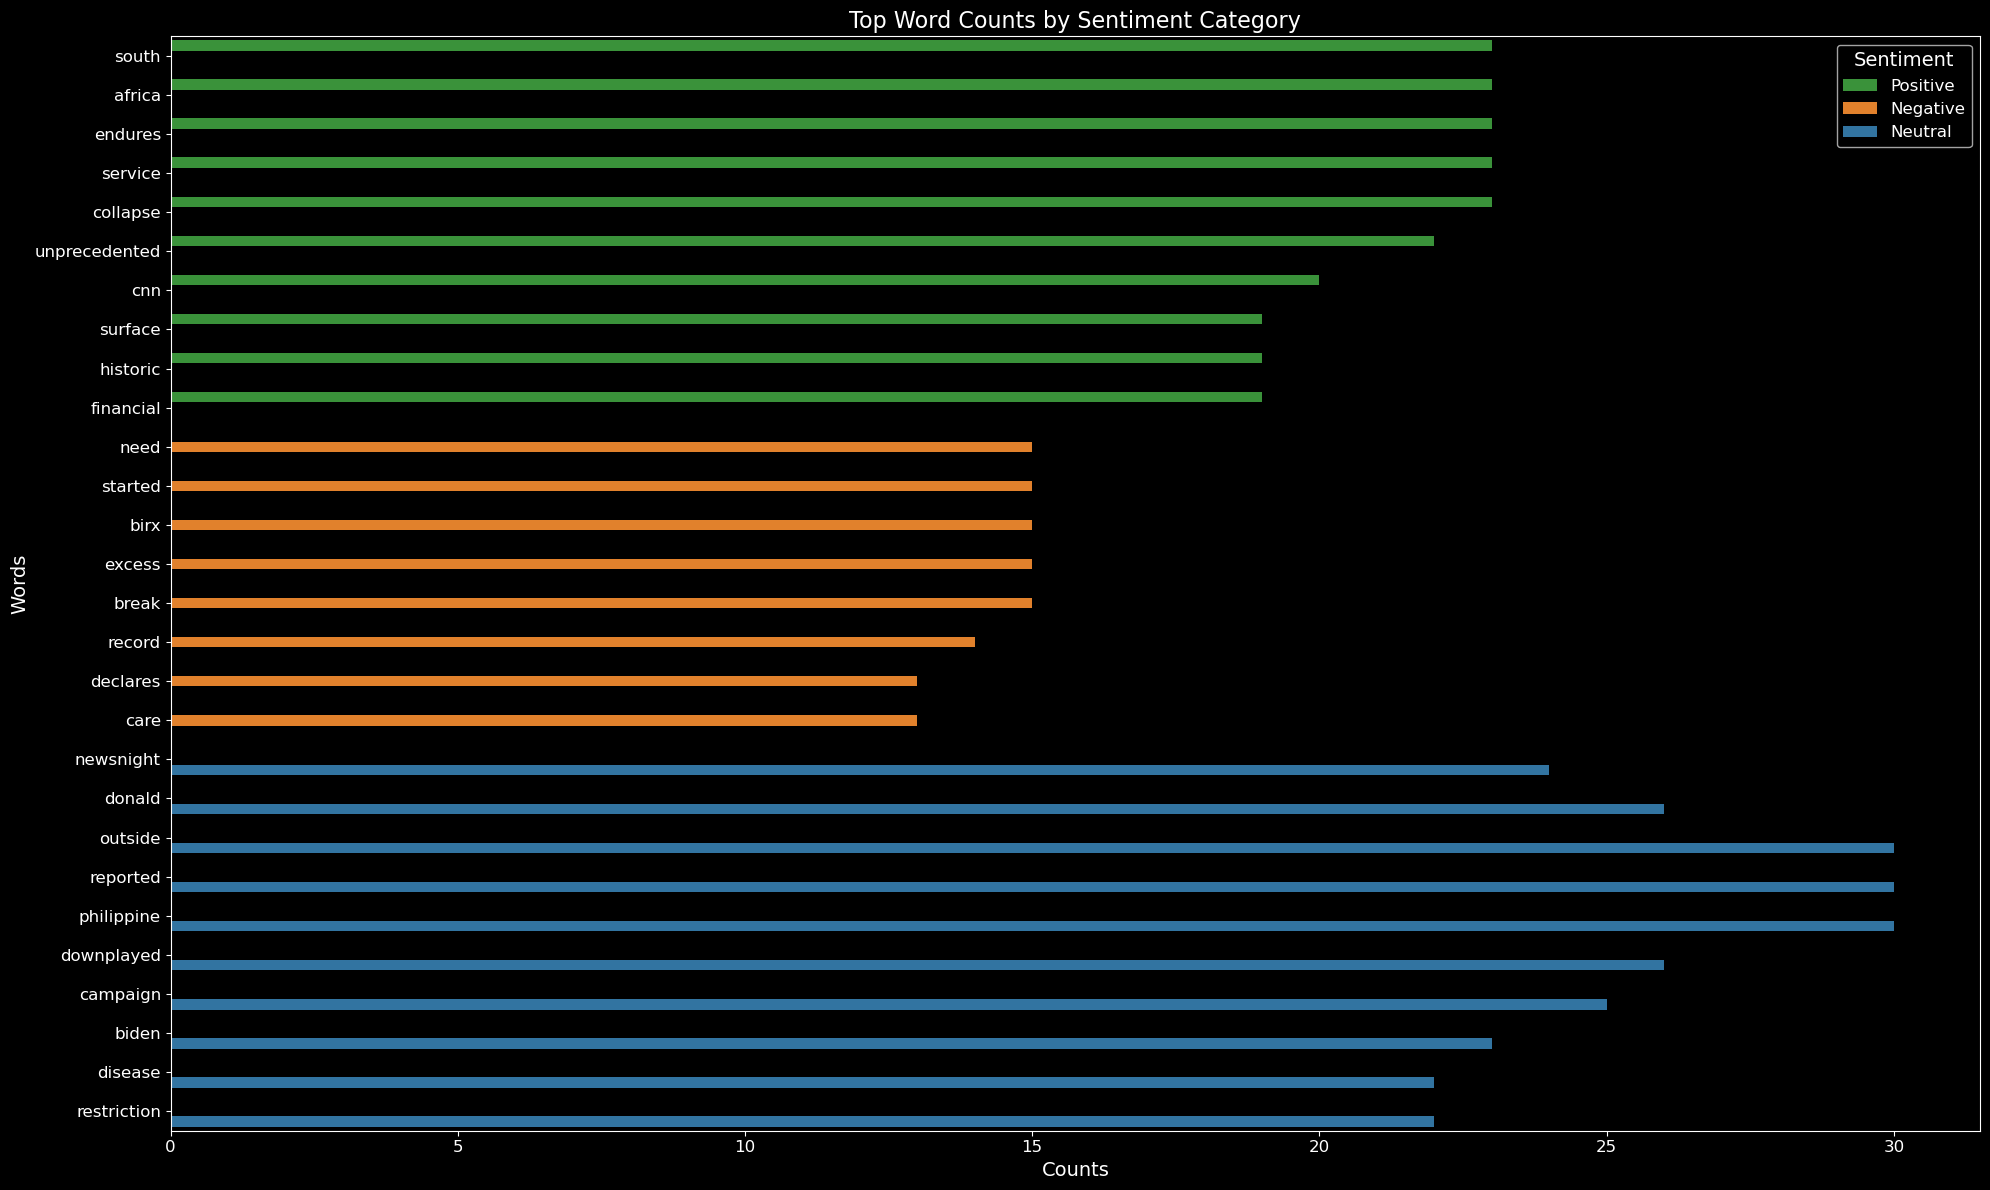

In [18]:
# Get the top 10 most common words for each sentiment
positive_common = dict(positive_words.most_common(10))
negative_common = dict(negative_words.most_common(10))
neutral_common = dict(neutral_words.most_common(10))
# Add category information to the dictionaries
positive_dict_with_category = {word: (count, "Positive") for word, count in positive_common.items()}
neutral_dict_with_category = {word: (count, "Neutral") for word, count in neutral_common.items()}
negative_dict_with_category = {word: (count, "Negative") for word, count in negative_common.items()}

# Combine the dictionaries into one dictionary
combined_dict_with_category = {**positive_dict_with_category, **negative_dict_with_category, **neutral_dict_with_category}

# Create a DataFrame from the combined dictionary
combined_df = pd.DataFrame(combined_dict_with_category.items(), columns=["Words", ("Counts", "Category")])

# Unpack the tuple column into separate columns
combined_df[["Counts", "Category"]] = pd.DataFrame(combined_df[("Counts", "Category")].tolist(), index=combined_df.index)

# Drop the tuple column
combined_df = combined_df.drop(columns=[("Counts", "Category")])

# Plot using Seaborn
plt.figure(figsize=(20, 12))
tab10_colors = plt.colormaps["tab10"](range(3))

# Create a custom palette with the first 3 colors
custom_palette = [tab10_colors[2], tab10_colors[1], tab10_colors[0]]

# Set the custom palette in Seaborn
sns.set_palette(custom_palette)
sns.barplot(data=combined_df,y="Words", x="Counts", hue="Category")
plt.title("Top Word Counts by Sentiment Category", fontsize=16)
plt.xlabel("Counts", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.xticks( fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Sentiment", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


Observation: 

In this analysis, there are 3 wordclouds and 1 bar chart in total to test the hypothesis that video titles that contain certain words are more likely to elicit certain sentiments in the comments. Looking at the wordclouds, we can see that there are 3 categories of sentiment(positive, negative and neutral) with different colors. In the wordcloud for Positive sentiment, the words with the largest size and saturation levels are "south", "africa","service","endures" and "collapse". These are the most frequent words appearing in the titles of the videos which has the tendency to receive positive reponses from the viewers. Moreover, this statement is substantiated by  the bar chart where the count figures for the aforementioned words are all approximately 23, which are the most appearences in their group. Moving on to the Negative sector, "need","started","birx", "excess" and "break" are the words that make the most impressive visual. They appear regularly in the video provoking negative comments with roughly 17 times for "need" and "started" and 15 times for "record". The Neutral wordcloud observes the striking showcase of the words: "reported", "outside" and "philippine". They all show up in the tiles 30 times and are usually associated with neutral response from users. This is also the highest number of appearences among the groups of category in the bar chart. This figure is followed up by the word "donald" and "downplayed" with nearly 26 times. All in all, the hypothesis proves true. 


...